# **DQN with Differential Privacy on Cartpole**

## Import

In [1]:
%matplotlib inline
!pip3 install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 52.6 MB/s eta 0:00:00


In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Acknowledgement

Code adapted from [this notebook](https://github.com/bentrevett/pytorch-rl/blob/master/dqn_working.ipynb).

In this notebook, we adapt DP-SGD to DQN on the Cartpole game.

## Initialize environments

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_env = gym.make('CartPole-v1', new_step_api=True)
test_env = gym.make('CartPole-v1', new_step_api=True)
if gym.__version__[:4] == '0.26':
    train_env = gym.make('CartPole-v1')
    test_env = gym.make('CartPole-v1')
elif gym.__version__[:4] == '0.25':
    train_env = gym.make('CartPole-v1', new_step_api=True)
    test_env = gym.make('CartPole-v1', new_step_api=True)
else:
    raise ImportError(f"Requires gym v25 or v26, actual version: {gym.__version__}")

### Seed

In [4]:
SEED = 42
train_env.reset(seed=SEED)
test_env.reset(seed=SEED+1)
np.random.seed(SEED)
torch.manual_seed(SEED);

## Replay Memory




In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## DQN algorithm




In [6]:
n_input = train_env.observation_space.shape[0]
n_hid = 128
n_output = train_env.action_space.n

In [7]:
print(n_input,n_hid,n_output)

4 128 2


In [8]:
class DQN(nn.Module):

    def __init__(self, n_input=n_input, n_hid=n_hid, n_output=n_output):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_input, n_hid)
        self.layer2 = nn.Linear(n_hid, n_hid)
        self.layer3 = nn.Linear(n_hid, n_output)
        
    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

## Action selection

In [9]:
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000

# Greedy policy
def select_action(env, state, policy_net):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

## Training

## Adapt code to DP framework

In [10]:
def compute_Q_batches(memory, batch_size):

    # If memory too small
    if len(memory) < batch_size:
        return None, None, None
    
    # Sample batch data
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions)) # Transpose the batch 

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    max_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        max_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
        
    # Compute the expected Q values
    expected_Q_values = reward_batch + gamma * max_values

    return state_batch, action_batch, expected_Q_values

## Compute gradient per sample

In [11]:
# Custom implementation of backpropagation
# Using vmap enables fast computation
from functorch import make_functional_with_buffers, vmap, grad

def compute_loss_stateless_model(params, buffers, state_sample, action_sample,
                                 expected_Q_values_sample, max_grad_norm,
                                 fmodel, criterion):
    batch = state_sample.unsqueeze(0)
    targets = expected_Q_values_sample.unsqueeze(0)

    predictions = fmodel(params, buffers, batch).gather(1, action_sample.unsqueeze(0))
    loss = criterion(predictions, targets.unsqueeze(1))
    return loss

ft_compute_grad = grad(compute_loss_stateless_model)
ft_compute_sample_grad = vmap(ft_compute_grad, in_dims=(None, None, 0, 0, 0, None, None, None))
ft_compute_sample_loss = vmap(compute_loss_stateless_model, in_dims=(None, None, 0, 0, 0, None, None, None))


In [12]:
def DP_update_policy(memory, policy_net, target_net, max_grad_norm, sigma,
                     batch_size, gamma, criterion, optimizer):

    # Recover batches
    state_batch, action_batch, expected_Q_values = compute_Q_batches(memory, batch_size)

    # If memory too small, no optimization
    if (state_batch is None) and (action_batch is None) and (expected_Q_values is None):
        return np.inf

    # Classic update
    if sigma == 0:

        # Recover Q_values
        Q_values = policy_net(state_batch).gather(1, action_batch)

        # Compute Huber loss
        loss = criterion(Q_values, expected_Q_values.unsqueeze(1))

        # Optimize the model
        optimizer.zero_grad()
        loss.backward()

    # DP update
    else:
        # Recover gradient for all samples of the batch
        fmodel, params, buffers = make_functional_with_buffers(policy_net)
        sample_grads = ft_compute_sample_grad(params, buffers, state_batch,
                                              action_batch, expected_Q_values,
                                              max_grad_norm, fmodel, criterion)
        losses = ft_compute_sample_loss(params, buffers, state_batch,
                                        action_batch, expected_Q_values,
                                        max_grad_norm, fmodel, criterion)
        loss = torch.mean(losses)

        # Differential Privacy: clip gradients and add gaussian noise on weights
        for i, param in enumerate(policy_net.parameters()):
  
          # Clip inplace gradients seperately for each sample of the batch
          sample_grad = sample_grads[i]
          torch.nn.utils.clip_grad_norm_(sample_grad, max_norm=max_grad_norm) 

          # Aggregate gradients to have a unique grad for the batch
          param.grad = torch.mean(sample_grad, dim=0) 

          # Add noise
          noise = torch.normal(mean=0, std=sigma*max_grad_norm, size=param.size()).to(device)
          param.grad += noise/batch_size # Gaussian noise

    # Optimize model
    optimizer.step()

    return loss.item()

In [13]:
# TAU is the update rate of the target network
TAU = 0.005

def DP_train(memory, env, policy_net, target_net, max_grad_norm,
             sigma, batch_size, gamma, criterion, optimizer):

    policy_net.train()
    target_net.eval()
    episode_reward = 0
    n_samples = 0

    # Initialize environment and state
    if gym.__version__[:4] == '0.26':
        state, _ = env.reset()
    elif gym.__version__[:4] == '0.25':
        state, _ = env.reset(return_info=True)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    for t in count():

        # Select action
        action = select_action(env, state, policy_net)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward += reward
        n_samples += 1
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Optimize policy with Differential Privacy
        loss = DP_update_policy(memory, policy_net, target_net, max_grad_norm,
                                sigma, batch_size, gamma, criterion, optimizer)

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = (policy_net_state_dict[key]*TAU 
                                          + target_net_state_dict[key]*(1-TAU))
        target_net.load_state_dict(target_net_state_dict)

        if done:
            break

    return loss, episode_reward

In [14]:
def evaluate(env, policy_net):
    global steps_done
    policy_net.eval()
    episode_reward = 0

    # Initialize environment and state
    if gym.__version__[:4] == '0.26':
        state, _ = env.reset()
    elif gym.__version__[:4] == '0.25':
        state, _ = env.reset(return_info=True)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    for t in count():

        # Select action
        action = select_action(env, state, policy_net)
        steps_done -= 1 # do not update steps_done
        observation, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward += reward
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Move to the next state
        state = next_state

        if done:
            break

    return episode_reward

In [15]:
batch_size = 128
gamma = 0.99
lr = 1e-4
LOG = 25
N_TRIALS = 25
REWARD_THRESHOLD = 475
if torch.cuda.is_available():
    MAX_EPISODES = 2000
else:
    MAX_EPISODES = 2000

# DP
noise_levels = [0, 0.1, 0.2, 0.4, 0.6] 

max_grad_norm = 0.1

train_rewards = np.zeros((len(noise_levels), MAX_EPISODES))
test_rewards = np.zeros((len(noise_levels), MAX_EPISODES))

for i, sigma in enumerate(noise_levels):
    train_env.reset(seed=SEED);
    test_env.reset(seed=SEED+1);
    
    print("-------------- Noise: sigma = {} ---------------\n".format(sigma))

    # Models
    policy_net = DQN().to(device)
    target_net = DQN().to(device)
    target_net.load_state_dict(policy_net.state_dict())
    
    # Optimizer
    optimizer = optim.AdamW(policy_net.parameters(), lr=lr, amsgrad=True)

    # Criterion
    criterion = nn.SmoothL1Loss()

    # Memory Buffer
    memory = ReplayMemory(10000)
    steps_done = 0  
    convergence = False
    
    for episode in range(MAX_EPISODES):
        if not convergence:
           # Train model
            loss, train_reward = DP_train(memory, train_env, policy_net,
                                          target_net, max_grad_norm, sigma,
                                          batch_size, gamma, criterion, optimizer)
            # Evaluate model
            test_reward = evaluate(test_env, policy_net)

            # Update rewards
            train_rewards[i][episode] = train_reward
            test_rewards[i][episode] = test_reward
            
            mean_train_rewards = np.mean(train_rewards[i][episode-N_TRIALS:episode+1])
            mean_test_rewards = np.mean(test_rewards[i][episode-N_TRIALS:episode+1])
            
            convergence = (mean_test_rewards) >= 475
            if convergence:
                print("Achieved convergence")
        else:
            train_rewards[i][episode] = train_rewards[i][episode-1]
            test_rewards[i][episode] = test_rewards[i][episode-1]
        
        if episode % LOG == 0:
            print(f'| Episode: {episode:3} | Train Reward: {train_reward:5.1f} | Test Reward: {test_reward:5.1f} |')

-------------- Noise: sigma = 0 ---------------



/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


| Episode:   0 | Train Reward:  45.0 | Test Reward:  13.0 |
| Episode:  25 | Train Reward:  19.0 | Test Reward:  11.0 |
| Episode:  50 | Train Reward:  10.0 | Test Reward:  12.0 |
| Episode:  75 | Train Reward:  16.0 | Test Reward:  19.0 |
| Episode: 100 | Train Reward:  10.0 | Test Reward:  14.0 |
| Episode: 125 | Train Reward:  10.0 | Test Reward:  11.0 |
| Episode: 150 | Train Reward:  10.0 | Test Reward:  10.0 |
| Episode: 175 | Train Reward:   9.0 | Test Reward:  10.0 |
| Episode: 200 | Train Reward:  10.0 | Test Reward:   8.0 |
| Episode: 225 | Train Reward: 107.0 | Test Reward: 134.0 |
| Episode: 250 | Train Reward: 140.0 | Test Reward: 153.0 |
| Episode: 275 | Train Reward: 111.0 | Test Reward: 120.0 |
| Episode: 300 | Train Reward: 127.0 | Test Reward: 173.0 |
| Episode: 325 | Train Reward: 212.0 | Test Reward: 132.0 |
| Episode: 350 | Train Reward: 146.0 | Test Reward:  88.0 |
| Episode: 375 | Train Reward: 221.0 | Test Reward: 251.0 |
| Episode: 400 | Train Reward: 164.0 | T

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3200: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::smooth_l1_loss. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:82.)
  return torch._C._nn.smooth_l1_loss(expanded_input, expanded_target, _Reduction.get_enum(reduction), beta)
/usr/local/lib/python3.8/dist-packages/torch/autograd/__init__.py:300: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::smooth_l1_loss_backward. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:82.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.8/dist-packages/torch/nn/utils/clip_grad.py:33: UserWarning: 

| Episode:  25 | Train Reward:  22.0 | Test Reward:  13.0 |
| Episode:  50 | Train Reward:   9.0 | Test Reward:  10.0 |
| Episode:  75 | Train Reward:   9.0 | Test Reward:  12.0 |
| Episode: 100 | Train Reward:  16.0 | Test Reward:  11.0 |
| Episode: 125 | Train Reward:  14.0 | Test Reward:  15.0 |
| Episode: 150 | Train Reward:  37.0 | Test Reward:  35.0 |
| Episode: 175 | Train Reward: 430.0 | Test Reward: 331.0 |
| Episode: 200 | Train Reward: 118.0 | Test Reward:  85.0 |
| Episode: 225 | Train Reward: 113.0 | Test Reward: 310.0 |
| Episode: 250 | Train Reward: 199.0 | Test Reward: 209.0 |
| Episode: 275 | Train Reward: 128.0 | Test Reward: 145.0 |
| Episode: 300 | Train Reward: 137.0 | Test Reward: 151.0 |
| Episode: 325 | Train Reward: 154.0 | Test Reward: 148.0 |
| Episode: 350 | Train Reward: 150.0 | Test Reward: 175.0 |
| Episode: 375 | Train Reward: 161.0 | Test Reward: 159.0 |
| Episode: 400 | Train Reward: 162.0 | Test Reward: 159.0 |
| Episode: 425 | Train Reward: 168.0 | T

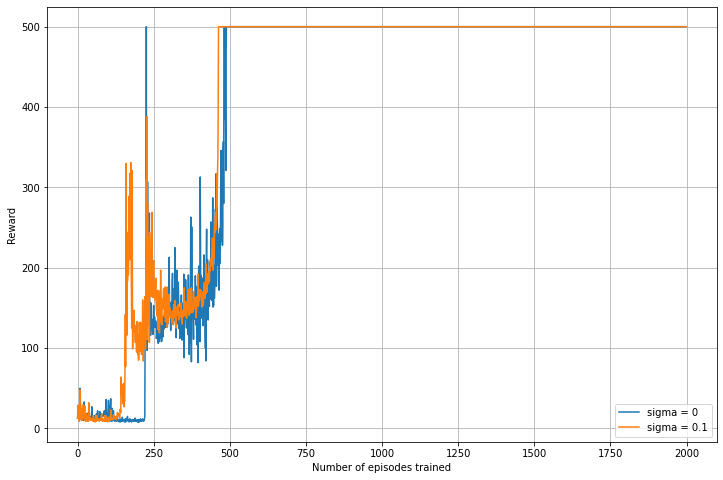

In [16]:
fig = plt.figure(figsize=(12,8))

for i, sigma in enumerate(noise_levels):
    plt.plot(test_rewards[i], label='sigma = {}'.format(sigma))

plt.xlabel('Number of episodes trained')
plt.ylabel('Reward')

plt.legend()
plt.legend(loc='lower right')
plt.grid()
plt.show()